# Adding Boundary Pores

In [1]:
import numpy as np
import openpnm as op
print(op.__version__)

2.1.0b1


Start by creating a Delaunay network.  Because it uses random base points it will better illustrate the process of adding boundary pores to arbitrary networks:

In [16]:
pn = op.network.Delaunay(num_points=200, shape=[1, 1, 0])
print(pn)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.network.Delaunay : net_01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.coords                                     258 / 258  
2     throat.conns                                    601 / 601  
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Labels                                        Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.all                                      258       
2     pore.back                                     14        
3     pore.bottom                                   258       
4     pore.boundary                                 58        
5     pore.front                                   

As can be seen in the above printout, the Delaunay class predefines many labels including boundaries and sides.  In fact, as can be seen in the plot below, the Delaunay class also adds boundary pores to the topology. (Note that the Delaunay network is generated randomly so your's will not look the same, nor have the same number of total pores and throats).  In this case, the location of the boundary poresis determined from the Voronoi cell that surrounds each Delaunay point, so the boundary cells apper to be randomly oriented relative to the internal pore they are connected with.  In the example that follows, we'll be adding boundary pores in a more simple way.

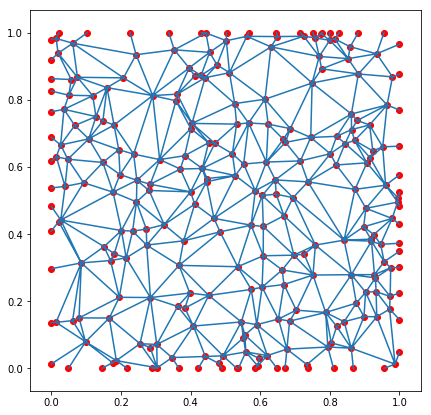

In [17]:
fig = op.topotools.plot_connections(network=pn)
fig = op.topotools.plot_coordinates(network=pn, fig=fig, c='r')
fig.set_size_inches((7, 7))

For the purpose of this tutorial, we will trim these boundary pores from the network since we'll be adding our own.

In [18]:
op.topotools.trim(network=pn, pores=pn.pores('boundary'))

Plotting the network now shows the missing pores.  Our goal will be re-add boundary pores to each face.

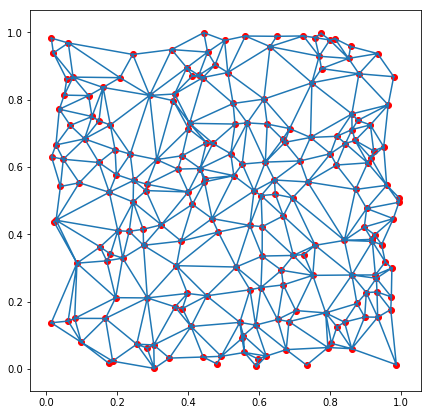

In [19]:
fig = op.topotools.plot_connections(network=pn)
fig = op.topotools.plot_coordinates(network=pn, fig=fig, c='r')
fig.set_size_inches((7, 7))

## Find surface pores
The ``topotools`` module in OpenPNM provides many handy helper functions for dealing with topology.  We'll first use the ``find_surface_pores`` function.  It works be specifying the location of a set of *marker* points outside the domain, then performing a Delaunay tessellation between these markers and the network pores.  Any pores that form a simplex with the marker points are considered to be on the surface.  By default OpenPNM will place *one* marker on each edge of the domain in an attempt to find all the surfaces.  In our case, we will specify them manually to only find one face.  

Specifying the markers can be a challenge.  If we only specify a single marker, we will only find a limited number of surface pores due to the way the triangulation works.

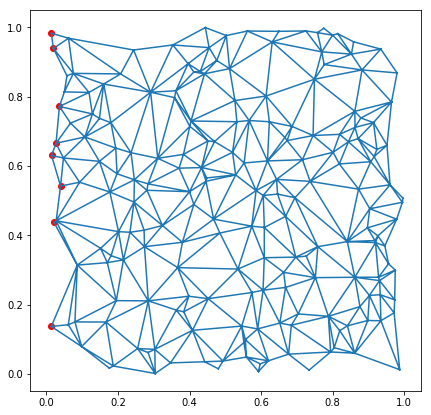

In [20]:
markers = np.array([[-0.1, 0.5]])
op.topotools.find_surface_pores(network=pn, markers=markers, label='left_surface')
fig = op.topotools.plot_connections(network=pn)
fig = op.topotools.plot_coordinates(network=pn, pores=pn.pores('left_surface'), fig=fig, c='r')
fig.set_size_inches((7, 7))

As can be seen, some of the pores in deeper recesses of the surface were not found by this method.  If we want to be certain of finding all the surface pores on the left side of the domain we can add more markers:

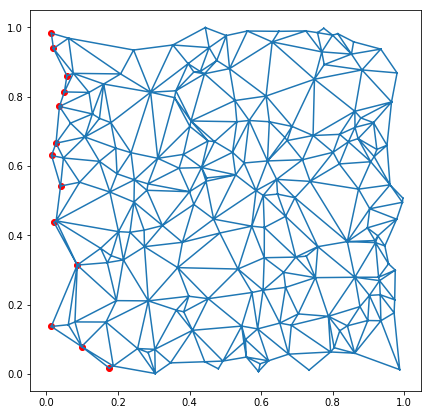

In [22]:
markers = np.array([[-0.1, 0.2], [-0.1, 0.4], [-0.1, 0.6], [-0.1, 0.8]])
op.topotools.find_surface_pores(network=pn, markers=markers, label='left_surface')
fig = op.topotools.plot_connections(network=pn)
fig = op.topotools.plot_coordinates(network=pn, pores=pn.pores('left_surface'), fig=fig, c='r')
fig.set_size_inches((7, 7))

Now we've captured several more pores.  In some cases we may actually get more than we wanted, including some that are more correctly on the bottom of the domain.  This is why finding surfaces requires a careful touch, although this problem becomes less important in domains with more pores.

## Cloning surface pores
Next we want to take the newly labeled surface pores and 'clone' them.  This creates new pores in the network that are physically located in the same place as their 'parents'.  They are also connected only to their 'parents' by default which is what we want, though this can be changed using the ``mode`` argument.  In the following code, we tell the function to clone the 'left_surface' pores and to give them a new label of 'left_boundary'.

In [24]:
op.topotools.clone_pores(network=pn, pores=pn.pores('left_surface'), labels=['left_boundary'])

Now that we've cloned the pores, we need to move them.  In this case we want them to all site on teh x=0 boundary face.  We can do this by directly altering the 'pore.coords' array:

In [25]:
Ps = pn.pores('left_boundary')
coords = pn['pore.coords'][Ps]
coords *= [0, 1, 1]
pn['pore.coords'][Ps] = coords

The above code will set the x-coordinate of each of the cloned pores to 0, while maining the other coordinates the same.  The result is:

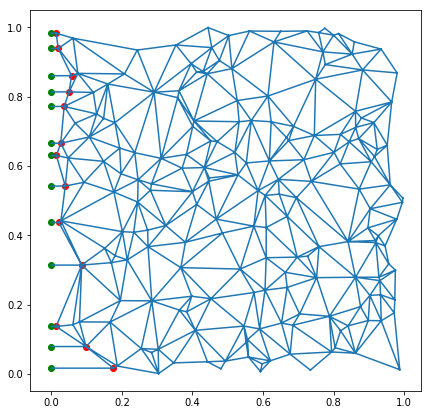

In [28]:
fig = op.topotools.plot_connections(network=pn)
fig = op.topotools.plot_coordinates(network=pn, pores=pn.pores('left_surface'), fig=fig, c='r')
fig = op.topotools.plot_coordinates(network=pn, pores=pn.pores('left_boundary'), fig=fig, c='g')
fig.set_size_inches((7, 7))